# Histopathologic Cancer Detection

El dataset descargado de https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview contiene pequeñas imágenes histopatológicas de tamaño 96x96. Una etiqueta "1" para una imagen quiere decir que al menos un pixel del centro de la imágen (de 32x32 pixeles) contiene tejido tumoral, mientras que un "0" quiere decir que la totalida del centro de la imagen (de 32x32 pixeles) es sano. Las etiquetas no consideran la región por duera del centro. 

El objetivo es realizar un modelo que clasifique las imágenes, es decir, determinar si dada una imagen, esta contiene tejido canceroso o no.

El proyecto será realizado en jupyter notebooks por su facilidad en la visualización.

Además, tomaremos solo en cuenta las imágenes del dataset de entrenamiento, el cual partiremos en tres para entrenamiento, validación y testeo. Esto es debido a que en el dataset original, las imagenes del dataset de testeo no contienen etiquetas, por lo que no sería posible comparar los resultados.

Comenzamos importando las librerías necesarias

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader,Dataset
from sklearn.metrics import confusion_matrix
from PIL import Image

Cargamos y visualizamos algunas imágenes del dataset

In [2]:
BASE_DIRECTORY=os.getcwd() #Obtenemos la dirección base del proyecto
BASE_DIRECTORY= os.path.dirname(BASE_DIRECTORY) #Subimos un nivel para no quedarnos en notebooks

train_path=BASE_DIRECTORY+"/data/train" #Complementamos para ir a la carpeta
print(os.listdir(train_path)[:10])

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '000020de2aa6193f4c160e398a8edea95b1da598.tif', '00004aab08381d25d315384d646f5ce413ea24b1.tif', '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif', '0000da768d06b879e5754c43e2298ce48726f722.tif', '0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif', '00010f78ea8f878117500c445a658e5857f4e304.tif', '00011545a495817817c6943583b294c900a137b8.tif', '000126ec42770c7568204e2f6e07eb9a07d5e121.tif', '00014e39b5df5f80df56f18a0a049d1cc6de430a.tif']


In [ ]:
#cargamos el csv con las etiquetas con pandas y lo ubicamos en un dataframe
csv_path_labels=BASE_DIRECTORY+"/data/train_labels.csv" #Ubicación del archivo csv
dataframe_labels=pd.read_csv(csv_path_labels) #Lo abrimos con pandas
dataframe_labels.head() #Vemos los primeros 5 registros con head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


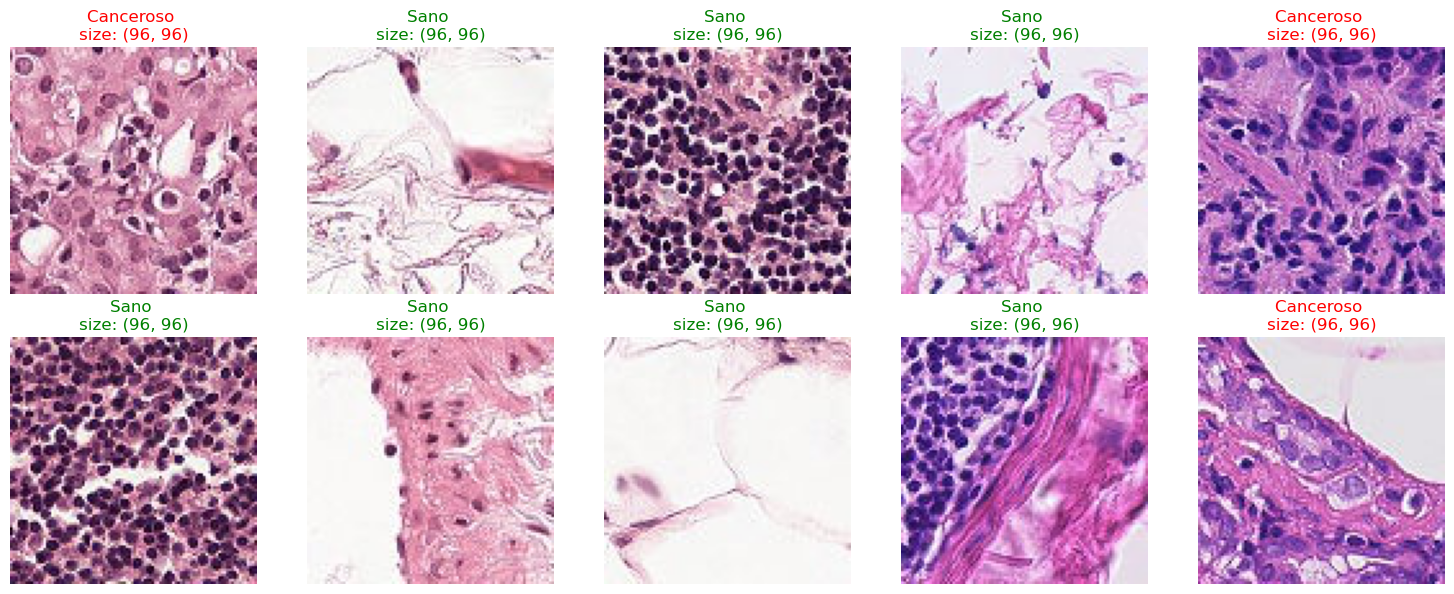

In [4]:
number_of_images_to_visualize=10 #Visualizamos solo 10 imágenes 
images_visualization_names=os.listdir(train_path)[:10]
samples = dataframe_labels.sample(number_of_images_to_visualize, random_state=43) #Elegimos las imágenes aleatorias del dataset

fig_visualization,axes_visualization=plt.subplots(2,5,figsize=(15,6)) #Creamos figura con subrgraficos 2 filas 5 columnas

#Recorremos las imágenes y las mostramos

position_in_plot=0
for i in images_visualization_names:
    img_name = i[:-4] #Ignoramos la extensión del achivo
    img_path=train_path+"/"+i #Tomamos el directorio de cada imágen
    size=Image.open(img_path).size #Vemos el tamaño de cada imagen
    label = dataframe_labels.loc[dataframe_labels["id"] == img_name, "label"].values[0] #Sacamos el label de cada imágen con ayuda de un loc
    label_text = f"Canceroso \nsize: {size}" if label ==1 else f"Sano \nsize: {size}" #Definimos la etiqueta con un codicional

    
    image_visualization=Image.open(img_path) #Abrimos la imagen

    ax_visualization=axes_visualization[position_in_plot//5,position_in_plot%5]
    ax_visualization.imshow(image_visualization)
    ax_visualization.set_title(label_text,fontsize=12,color="red" if label ==1 else "green" )
    ax_visualization.axis("off")
    position_in_plot+=1


plt.tight_layout()
plt.show()

Notemos que todas las imágenes son de 96x96

 Veamos ahora cuantos tejidos cancerosos y sanos tenemos con un gráfico de barras

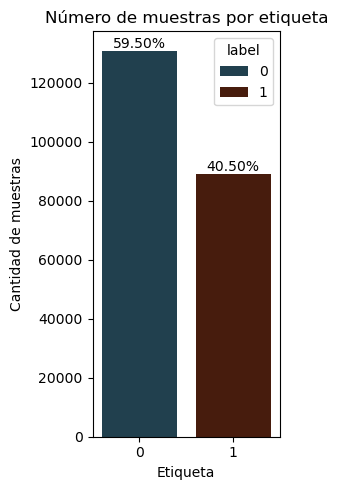

In [5]:
plt.figure(figsize=(3,5))

percentage_0=(dataframe_labels.groupby(['label']).count().values[0]*100)/(dataframe_labels.groupby(['label']).count().values[0]+dataframe_labels.groupby(['label']).count().values[1])
percentage_1=(dataframe_labels.groupby(['label']).count().values[1]*100)/(dataframe_labels.groupby(['label']).count().values[0]+dataframe_labels.groupby(['label']).count().values[1])


sns.barplot(dataframe_labels.groupby(['label']).count(),x="label",y='id',palette="berlin",hue="label") #0 significa no canceroso mientras que 1 significa canceroso

plt.text("0",dataframe_labels.groupby(['label']).count().values[0]+900,f'{'%.2f'%(float(percentage_0[0]))}%',ha='center')
plt.text("1",dataframe_labels.groupby(['label']).count().values[1]+900,f'{'%.2f'%(float(percentage_1[0]))}%',ha='center')
plt.title("Número de muestras por etiqueta")
plt.ylabel("Cantidad de muestras")
plt.xlabel("Etiqueta")
plt.tight_layout()
plt.show()

Así, vemos que el 59.5% de las imágenes corresponden a tejidos sanos, mientras que el 40.5% corresponde a tejido canceroso

Ahora, recordemos que solo nos interesa el centro de la imágen de 32x32 pixeles. Así, recortaremos esta sección:

In [6]:
#Preprocesamos las imágenes con torchvision.transforms

transform = transforms.Compose([
    transforms.CenterCrop(32), #Recortamos la region central de 32x32
    transforms.ToTensor(), #Convertimos a tensor
    #transforms.Normalize(mean=[0.5],std=[0.5]) #Normalización, el modelo aprende mejor cuando los datos están centralizados en 0
])

Ahora creamos el nuevo dataset, donde juntamos las imágenes y las etiquetas en uno solo, y posteriormente dividimos en entrenamiento, validación y testeo

In [27]:
#Preparamos imagenes 32x32 y le añadimos la etiqueta
class CancerDataset(Dataset): #Definimos la clase CancerDataset, que hereda de la clase Dataset, base incluida en torch para los datasets
    def __init__(self,csv_file,img_folder,transform): #Inicializamos la instancia con los atributos de instancia csv_file, img_folder y transform
        self.data=pd.read_csv(csv_file) #No usamos super, ya que Dataset es una clase abstracta, es decir, su __init__() no contiene lógica que necesitemos heredar, se puede incluir, pero no hace nada util
        self.img_folder=img_folder
        self.transform=transform
    def __len__(self): #Dunder_method para len, con esto podemos luego dividir el dataset
        return len(self.data)
    def __getitem__(self,idx): #Dunder method para acceder a los elementos del dataset
        img_name = os.path.join(self.img_folder, self.data.iloc[idx, 0] + ".tif") #Accedemos a la primera columna del dataframe data que contiene las id de las imagenes
        label = self.data.iloc[idx, 1] #accedemos al label de la imagen en cuestion
        image = Image.open(img_name) #abrimos la imagen 
        if self.transform:
            image = self.transform(image) #aplicamos las transformaciones sobre la imagen abierta
        return image, label #retornamos la nueva imagen con el mismo label

dataset = CancerDataset(csv_file=csv_path_labels, img_folder=train_path+'/', transform=transform) #Instanciamos la clase CancerDataset en el objeto dataset

#Tamaños de las divisiones del dataset
train_size =int(0.8*len(dataset))
val_size=int(0.15*len(dataset))
test_size=len(dataset)-(train_size+val_size)

#Dividimos el dataset
torch.manual_seed(40)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size]) #Separa el dataset en subconjuntos disyuntos, para esto definimos el getitem, ya que random_split itera sobre el dataset

#dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Visualizamos una imagen antes y despues de las transformaciones

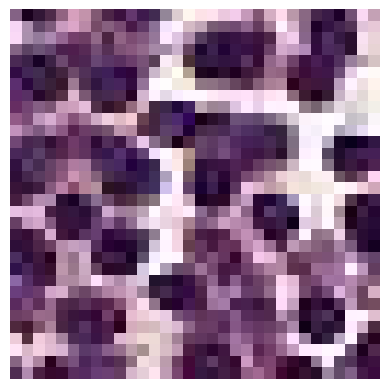

Estado: 0


In [28]:
img_original, label = train_dataset[13423] #Puede hacerse gracias a que hicimos el __getitem__

def imshow(tensor):
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convertir formato (C, H, W) a (H, W, C) C es canales, H es alto y W es ancho... PyTorch representa las imagenes como tensor que es distinto a como son representadas en librerías como matplotlib
    plt.imshow(tensor)
    plt.axis("off")
    plt.show()

imshow(img_original)
print(f"Estado: {label}")

Ahora, como ya tenemos el dataset, determinamos un modelo de clasifiación binaria básico: este contará con solo dos capas convolucionales y dos capas lineales. Usaremos maxpool2d para reducir la dimensionalidad y relu como función de activación, finalmente para determinar la probabilidad usamos una función sigmoide.

In [29]:
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()

        # Primera capa convolucional (Conv2D + ReLU + MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 32 filtros
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 filtros
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce tamaño a la mitad

        # Capa completamente conectada (FC)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Para imágenes de 32x32
        self.fc2 = nn.Linear(128, 1)  # Salida binaria (0 = sano, 1 = canceroso)

        # Activación
        self.sigmoid = nn.Sigmoid()  # Para convertir la salida en probabilidad

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Aplanar para FC
        x = F.relu(self.fc1(x))  # Primera capa FC
        x = self.sigmoid(self.fc2(x))  # Segunda capa FC con activación Sigmoid
        return x

# Instanciar el modelo
modelo = CancerClassifier()
print(modelo)

CancerClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Ahora, de ser posible cargamos el dataset a GPU al igual que el modelo, ya que es más rápido. Y definimos la Entropía cruzada binaria como función de perdida y para optimizar los pesos y sesgos usamos Descenso estocástico de Gradiente con una tasa de aprendizaje del 0.001

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Detectar GPU
modelo.to(device)
# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Binary Cross Entropy para clasificación binaria
optimizer = optim.SGD(modelo.parameters(), lr=0.001)

Ahora entrenamos el modelo en solo 10 épocas (más épocas pueden hacer un mejor modelo)

In [93]:
num_epochs = 10
best_val_loss = float("inf")  # Para guardar el mejor modelo
best_epoch = -1
models_path=BASE_DIRECTORY+"/models/"
train_loss=[]
validation_loss=[]
train_accuracy=[]
validation_accuracy=[]


for epoch in range(num_epochs):
    modelo.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images,labels in train_loader:
        
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Convertir etiquetas a float

        optimizer.zero_grad()
        outputs = modelo(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted_train = (outputs > 0.5).float()
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)


    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    avg_train_accuracy = 100 * correct_train / total_train
    train_accuracy.append(avg_train_accuracy)

    modelo.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = modelo(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    validation_loss.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    validation_accuracy.append(val_accuracy)
    print(f"Época [{epoch+1}/{num_epochs}] - Pérdida entrenamiento: {avg_train_loss:.4f} - Pérdida validación: {avg_val_loss:.4f} - Precisión validación: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(modelo.state_dict(), models_path+"mejor_modelo.pth")
        print("Guardando nuevo mejor modelo.")

print(f"Entrenamiento finalizado. Mejor modelo en la época {best_epoch + 1}")




🔹 Época [1/10] - Pérdida entrenamiento: 0.6202 - Pérdida validación: 0.5775 - Precisión validación: 71.48%
Guardando nuevo mejor modelo.
🔹 Época [2/10] - Pérdida entrenamiento: 0.5440 - Pérdida validación: 0.5358 - Precisión validación: 74.54%
Guardando nuevo mejor modelo.
🔹 Época [3/10] - Pérdida entrenamiento: 0.5221 - Pérdida validación: 0.5317 - Precisión validación: 74.54%
Guardando nuevo mejor modelo.
🔹 Época [4/10] - Pérdida entrenamiento: 0.5138 - Pérdida validación: 0.5136 - Precisión validación: 75.96%
Guardando nuevo mejor modelo.
🔹 Época [5/10] - Pérdida entrenamiento: 0.5067 - Pérdida validación: 0.5065 - Precisión validación: 76.20%
Guardando nuevo mejor modelo.
🔹 Época [6/10] - Pérdida entrenamiento: 0.4983 - Pérdida validación: 0.4958 - Precisión validación: 76.97%
Guardando nuevo mejor modelo.
🔹 Época [7/10] - Pérdida entrenamiento: 0.4892 - Pérdida validación: 0.4939 - Precisión validación: 77.34%
Guardando nuevo mejor modelo.
🔹 Época [8/10] - Pérdida entrenamiento: 0

Veamos ahora como evoluciona la pérdida y precisión de la validación en el tiempo

In [44]:
train_loss=[0.6202,0.5440,0.5221,0.5138,0.5067,0.4983,0.4892,0.4815,0.4750,0.4693]
validation_loss=[0.5775,0.5358,0.5317,0.5136,0.5065,0.4958,0.4939,0.4970,0.4919,0.4784]
validation_accuracy=[71.48,74.54,74.54,75.96,76.20,76.97,77.34,75.84,76.09,78.53]

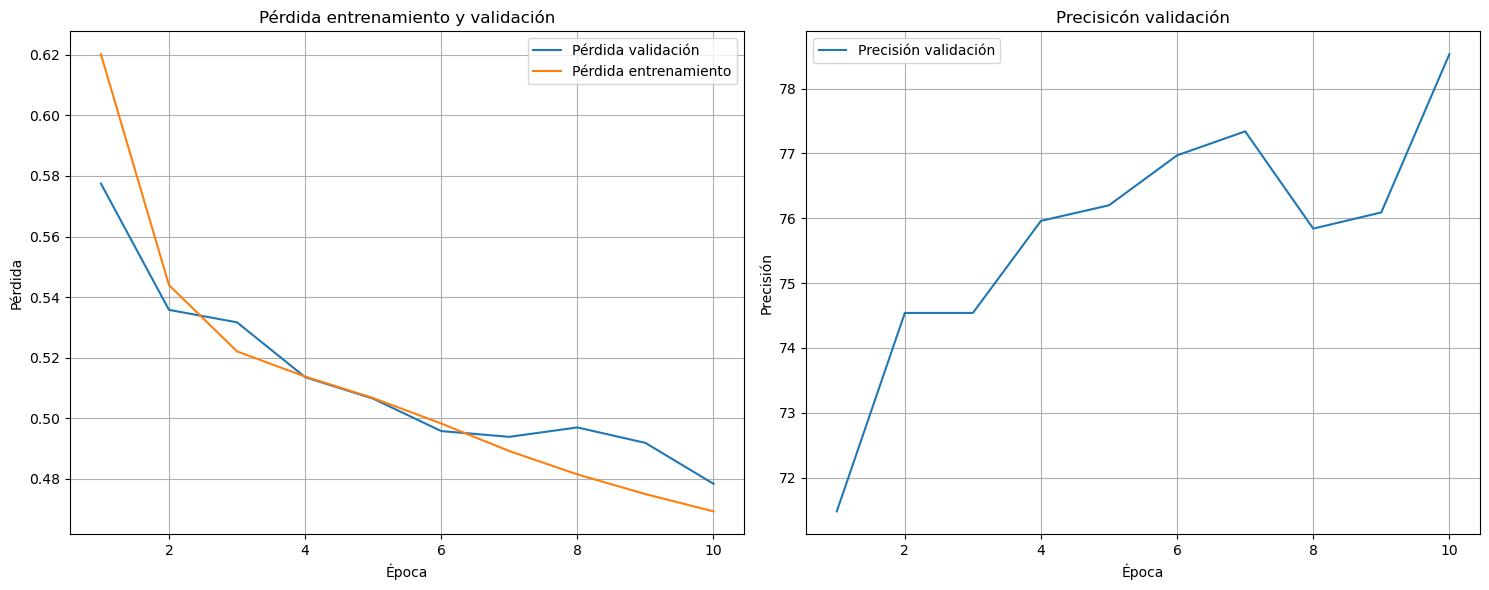

In [50]:
fig,axes=plt.subplots(1,2,figsize=(15,6))
x=np.linspace(1,10,10)

axes[0].plot(x,validation_loss,label='Pérdida validación')
axes[0].plot(x,train_loss,label='Pérdida entrenamiento')
axes[0].set_title("Pérdida entrenamiento y validación")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Pérdida")
axes[0].legend()
axes[0].grid()

axes[1].plot(x,validation_accuracy,label='Precisión validación')
axes[1].set_title("Precisicón validación")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("Precisión")
axes[1].legend()
axes[1].grid()


plt.tight_layout()
plt.show()
    

Gracias al gráfico podemos ver como se disminuye la pérdida y la precisión en general aumenta gradualmente. Notemos que las pérdidas siguen una trayectoria similar, lo que indica que no hay sobreajuste. Veamos tambien que siguen trayectorias descendentes (y ascendentes) incluso en la época 10, lo que parece indicar que si se agregaran más épocas obtendríamos mejores resultados.

Ahora, seleccionaremos aleatoriamente 10 imágenes del dataset de testeo, y aplicaremos el modelo, para posteriormente mostrarlo en un gráfico... si el modelo acierta lo pondremos en verde y si falla en rojo. Cargamos entonces las 10 imagenes y etiquetas.

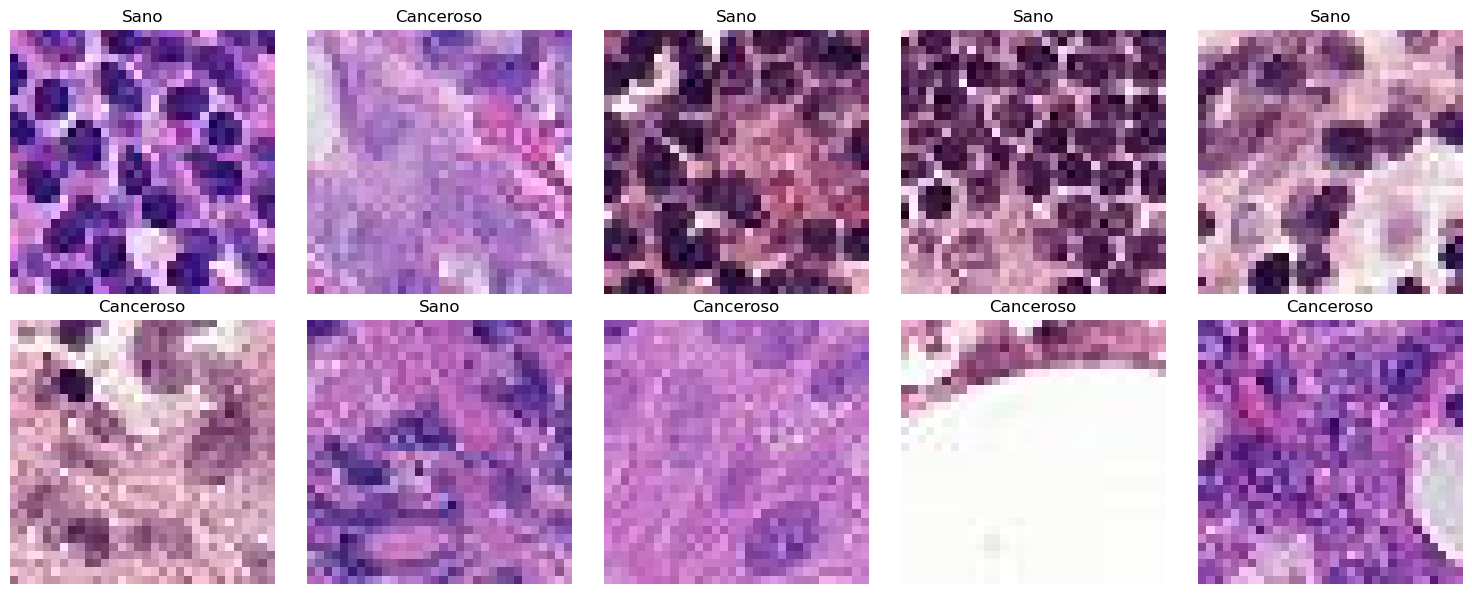

In [31]:
torch.manual_seed(40)  #Hacemos que los batch random usen la misma semilla
images,labels = next(iter(test_loader)) #obtenemos un batch aleatorio del dataloader de testeo

fig_visualization,axes_visualization=plt.subplots(2,5,figsize=(15,6)) #Creamos figura con subrgraficos 2 filas 5 columnas

#Recorremos las imágenes y las mostramos

position_in_plot=0
for i in range(10): #usamos las primeras 10 imagenes del batch
    
    image=images[i]
    label =labels[i].item()
    image = image.numpy().transpose((1, 2, 0)) #transformamos al formato que usa matplotlib
    label_text = f"Canceroso" if label ==1 else f"Sano" #Definimos la etiqueta con un codicional


    ax_visualization=axes_visualization[position_in_plot//5,position_in_plot%5]
    ax_visualization.imshow(image)
    ax_visualization.set_title(label_text,fontsize=12,color="black")
    ax_visualization.axis("off")
    position_in_plot+=1


plt.tight_layout()
plt.show()

Las pasamos por el modelo:

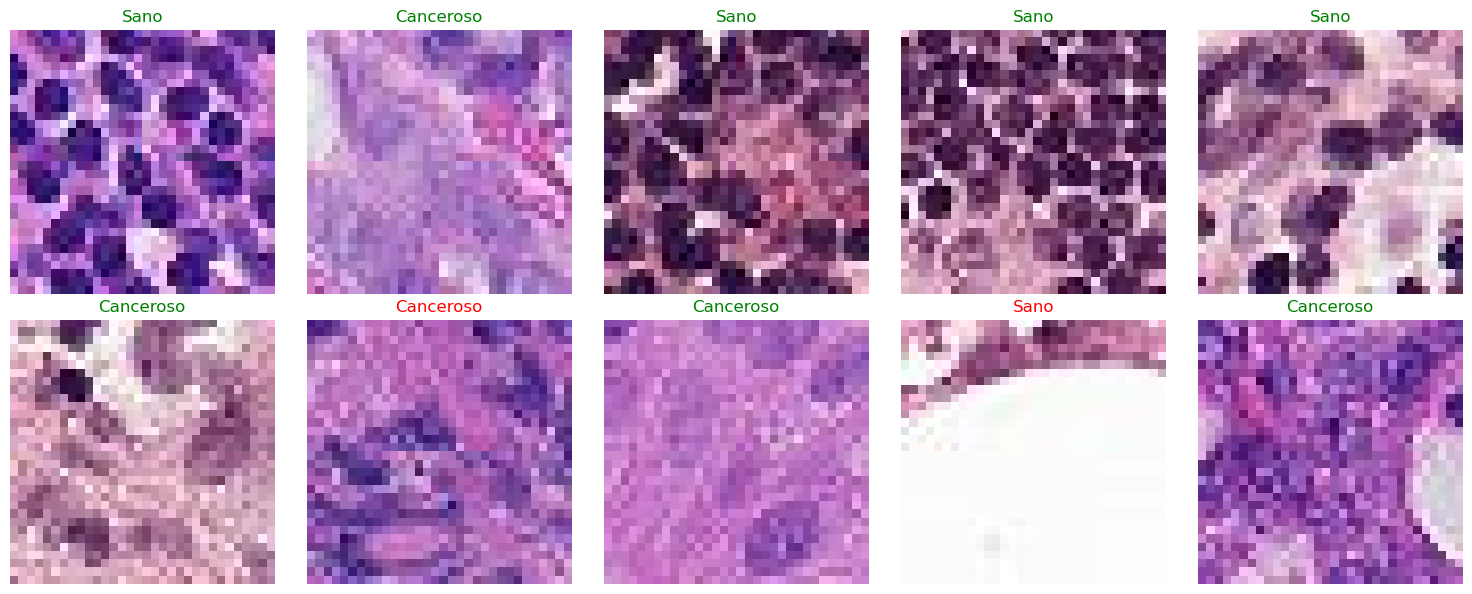

In [32]:
models_path=BASE_DIRECTORY+"/models/"
images,label=images.to(device), labels.to(device).float().view(-1, 1) #movemos los tensores a GPU si está disponible, convertimos labels a float y ajustamos la forma del tensor con view para que tenga una dimension adicional, esto es necesario porque BCELoss espera etiquetas con la forma (batch_size,1)
modelo.load_state_dict(torch.load(models_path+"mejor_modelo.pth")) #cargamos el modelo guardado
modelo.eval() #lo ponemos en modo evaluador


fig_visualization,axes_visualization=plt.subplots(2,5,figsize=(15,6)) #Creamos figura con subrgraficos 2 filas 5 columnas
position_in_plot=0
for i in range(10):
    
    image=images[i].unsqueeze(0) #el modelo espera batches, por tanto agregamos una nueva dimension al tensor de la imagen para que el modelo lo tome como un batch de tamaño 1
    label =labels[i].item() #obtenemos el label de la imágen
    with torch.no_grad():  # Desactivar cálculo de gradientes (más eficiente)
        output = modelo(image) #guardamos la predicción del modelo en output
    probability=output.item() #nos bota una probabilidad
    if probability > 0.5:
        model_label=1 #si la probabilidad es de más del 50% el tejido es canceroso, por lo que le asignaremos la etiqueta 1
    else:
        model_label=0
    image=image.squeeze(0) #eliminamos la dimension adicional que habíamos creado con unsqueeze
    image = image.numpy().transpose((1, 2, 0)) #transformamos para el formato de matplotlib
    label_text = f"Canceroso" if model_label ==1 else f"Sano" #Definimos la etiqueta con un codicional

    ax_visualization=axes_visualization[position_in_plot//5,position_in_plot%5]
    ax_visualization.imshow(image)
    ax_visualization.set_title(label_text,fontsize=12,color="green" if label ==model_label else "red" ) #el color verde es si la etiqueta predicha coincide con el valor real
    ax_visualization.axis("off")
    position_in_plot+=1
plt.tight_layout()
plt.show()

Vemos que el modelo acierta en 8 de las 10 imágenes pasadas. Lo que indicaría un valor cercano al 80% de acierto... veamos si esto es así evaluando sobre todo el conjunto de testeo

Evaluamos el desempeño general sobre todo el dataset de testeo

In [40]:
modelo.load_state_dict(torch.load(models_path+"mejor_modelo.pth"))
modelo.eval()

correct = 0
total = 0
test_loss = 0.0

all_preds = []
all_labels = [] #usados más adelante para la matriz de confusión


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        outputs = modelo(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float() #con outputs > 0.5 queda un tensor booleano en el que cada output pertenece a una imágen, y con .float se le asigna 1 si es true o 0 si es false
        correct += (predicted == labels).sum().item() #se suman solo si las etiquetas predichas son iguales a las reales
        total += labels.size(0) #se obtiene el tamaño del label

        all_preds.extend(predicted.cpu().numpy()) #así all_preds guarda todas las predicciones de los batches
        all_labels.extend(labels.cpu().numpy()) #así all_labels guarda todas las etiquetas reales de los batches

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Evaluación en Test - Pérdida: {avg_test_loss:.4f} - Precisión: {test_accuracy:.2f}%")

Evaluación en Test - Pérdida: 0.4657 - Precisión: 79.27%


Vemos que tenemos una precisión del 79.27%, es decir que de cada 10 imágenes acierta en 7.9. Ahora, pasaremos a ver cuantas de las predicciones resultaron en falsos negativos, falsos positivos, verdaderos negativos o verdaderos positivos, con ayuda de la matriz de confusión.

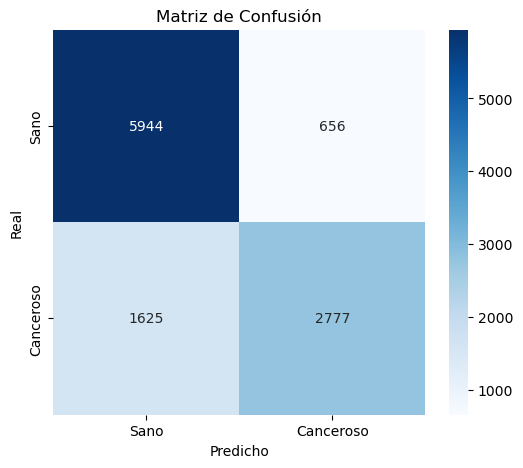

In [43]:
#matriz de confusión

confusion_matrix_model=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_model, annot=True, fmt="d", cmap="Blues", xticklabels=["Sano", "Canceroso"], yticklabels=["Sano", "Canceroso"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

Así, tenemos:
* 5944 casos sanos correctamente identificados por el modelo
* 2777 casos cancerosos correctamente identificados por el modelo
* 1625 casos cancerosos que el modelo no detectó y clasificó erroneamente como sanos
* 656 casos sanos que el modelo identificó erroneamente como cancerosos

Así, tenemos que el modelo acierta en un 79% de los casos. Sin embaro, hay 1625 tejidos cancerosos no detectados en comparación con 656 tejidos sanos erróneamente clasificados, esto quiere decir que el modelo deja pasar muchos tejidos cancerosos como si fueran sanos, lo cual, en un contexto médico es preocupante.

Más exactamente, podemos usar el recall, para evaluar la tasa de verdaderos positivos:
$$
Recall= \frac{\text{verdaderos positivos}}{\text{verdaderos positivos} + \text{falsos negativos}} = \frac{2777}{2777+1625} = 0.6308
$$

Esto quiere decir que el modelo detecta solo un 63% de los casos de cáncer.



Tambien tenemos la precisión del modelo, que es:
$$
Precision=\frac{\text{verdaderos positivos}}{\text{verdaderos positivos} + \text{falsos positivos}} = \frac{2777}{2777 + 656} = 0.8089
$$
Es decir tenemos un 80.8% de casos positivos detectados por el modelo.

La especificidad nos dice la tasa de verdaderos negativos:
$$
Especificity=\frac{\text{verdaderos negativos}}{\text{verdaderos negativos}+\text{falsos positivos}} = \frac{5944}{5944 + 656} = 0.90
$$
Es decir que el modelo detecta un 90% de los casos sanos.

Para una mejora, el modelo podría necesitar agregar más épocas, agregarmás capas ocultas al modelo así como cambiar el método de optimización, pasando de usar el Descenso estocástico del gradiente a ADAM, reducir el ratio de aprendizaje, o tocar la sensibilidad del modelo (cambiar la probabilidad de 0.5 a una más baja), entre otras.

## Conclusión
Podemos ver que el modelo pareciese tener un desempeño aceptable, ya que tiene una exactitud del 90%, sin embargo, si analizamos esto más a fondo, vemos que el modelo tiene más problemas para detectar tejido canceroso, con solo un 63% de acierto, que en un ámbito real, es para lo que sería usado.